In [ ]:
pip install pyclustertend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 649.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances,silhouette_score
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from numpy.random import uniform
from random import sample



In [ ]:
df=pd.read_csv("/content/archive.zip")
df

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [ ]:
#count null values
df.isnull().sum()

,0
CustomerID,0
Genre,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [ ]:
#features
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [ ]:
features=['Annual Income (k$)', 'Spending Score (1-100)']

In [ ]:
#standardize the features
scaler=StandardScaler()
scaled_df=scaler.fit_transform(df[features])


In [ ]:
#DO hopkins test
def hopkins (X, m=10):
  #compute the hopkins statistic for the dataset X, m:number of samples (default is 10% of the dataset if not provided)
  n, d=X.shape
  m=min(m,n)
  nbrs=NearestNeighbors(n_neighbors=1).fit(X)
  rand_x=uniform(np.min(X, axis=0),np.max(X,axis=0),(m,d))
  ujd=sum(nbrs.kneighbors(rand_x, return_distance=True)[0])
  sample_X=np.array(sample(list(X),m))
  wjd=sum(nbrs.kneighbors(sample_X, return_distance=True)[0])
  if (ujd+wjd)==0:
    return 0.5
  H=ujd/(ujd+wjd)
  return H

hopkins_statistic=hopkins(scaled_df, m=100)
print("Hopkins Statistic:", hopkins_statistic)

Hopkins Statistic: [1.]


Calculating clusters: 100%|██████████| 9/9 [00:00<00:00, 72.07it/s]


Number of clusters: 2, Silhouette score: 0.26697438853700084
Number of clusters: 3, Silhouette score: 0.29666598738505084
Number of clusters: 4, Silhouette score: 0.4292139470811923
Number of clusters: 5, Silhouette score: 0.4015887376581453
Number of clusters: 6, Silhouette score: 0.5343029785656783
Number of clusters: 7, Silhouette score: 0.4478357167397548
Number of clusters: 8, Silhouette score: 0.42814781959041126
Number of clusters: 9, Silhouette score: 0.41083614024901516
Number of clusters: 10, Silhouette score: 0.37283527200963557


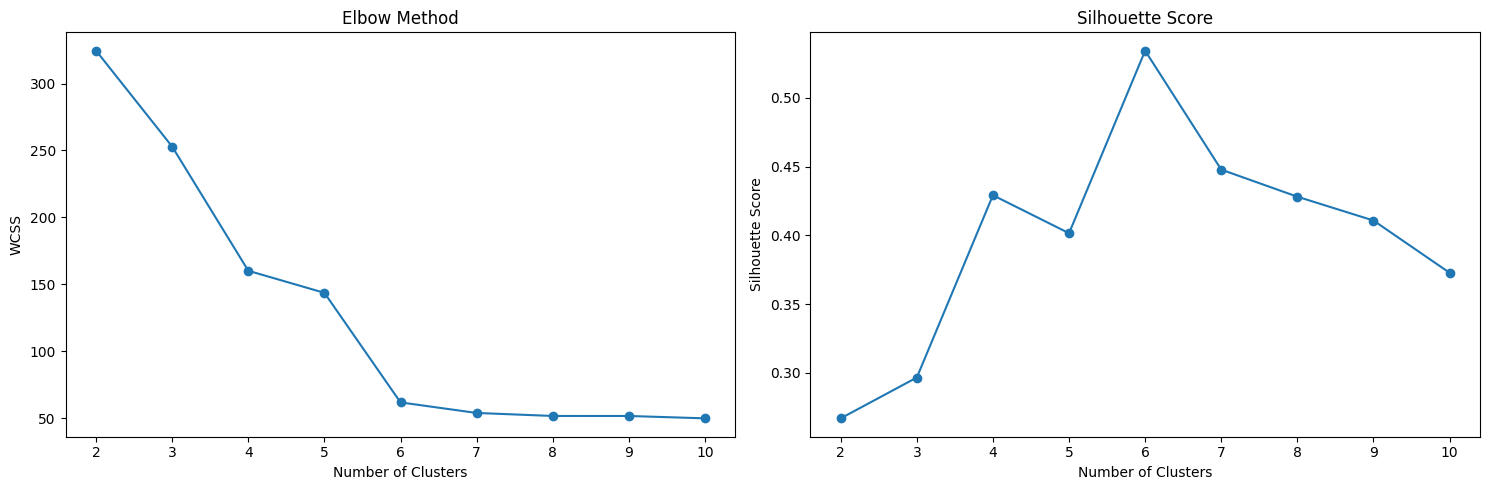


Optimal number of clusters: 6


In [ ]:
#Make kmedoids function
class KMedoids:
    def __init__(self, n_clusters=3, max_iter=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
    def fit(self, X):
        np.random.seed(self.random_state)

        #Step 1: Initialize random select k medoids
        n_samples = X.shape[0]
        self.medoids=np.random.choice(n_samples, self.n_clusters, replace=False)

        for _ in range(self.max_iter):
          #Step 2: Assign each point to the closest medoids
          distances = pairwise_distances(X, X[self.medoids])
          self.labels_=np.argmin(distances, axis=1)

          #Step 3: Update medoids
          new_medoids=[]
          for i in range(self.n_clusters):
            cluster_points=X[self.labels_==i]
            distances_in_cluster=pairwise_distances(cluster_points)
            total_distances=np.sum(distances_in_cluster, axis=1)
            new_medoid_idx=np.argmin(total_distances)   #Find point with smallest total distance
            #get the original index of the new medoids
            original_idx=np.where((X==cluster_points[new_medoid_idx]).all(axis=1))[0][0]
            new_medoids.append(original_idx) #append to list

          new_medoids=np.array(new_medoids)

          #check for convergence
          if np.array_equal(self.medoids, new_medoids):
            break

          self.medoids=new_medoids
        self.cluster_centers_=X[self.medoids]
        return self

    #Predict function
    def predict(self, X):
        distances=pairwise_distances(X, self.cluster_centers_)
        return np.argmin(distances, axis=1)

#elbow method to find the optimal number of cluster
wcss=[]
silhouette_scores=[]
range_n_clusters=range(2,11)

for n_clusters in tqdm(range_n_clusters, desc="Calculating clusters"):
  kmedoids=KMedoids(n_clusters=n_clusters, random_state=42)
  cluster_labels=kmedoids.fit(scaled_df).labels_


  #Calculate distances
  distances=pairwise_distances(scaled_df, kmedoids.cluster_centers_)
  wcss.append(np.sum(distances[np.arange(scaled_df.shape[0]), cluster_labels]**2))

  #Silhoutte score
  silhouette_avg=silhouette_score(scaled_df, cluster_labels)
  silhouette_scores.append(silhouette_avg)
  print(f"Number of clusters: {n_clusters}, Silhouette score: {silhouette_avg}")


#plotting
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(range_n_clusters, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')

plt.tight_layout()
plt.show()

#visualizing
optimal_k=range_n_clusters[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")



In [ ]:
kmedoids=KMedoids(n_clusters=optimal_k, random_state=42).fit(scaled_df)
plt.figure(figsize=(8,6))
plt.scatter(scaled_df[:,0], scaled_df[:,1], c=kmedoids.labels_, cmap='viridis',s=100)
plt.scatter(kmedoids.cluster_centers_[:,0], kmedoids.cluster_centers_[:,1], c='red', marker='x', s=100, linewidths=2)
plt.title("K-Medoids Clustering")
plt.show()